In [1]:
import tensorflow as tf
import os, re, random

# Data

The dataset consists of a collection of dialogue from films. We will attempt to train a basic transformer-based chatbot, that can predict a response to a given block of text.

In [2]:
dataset_download = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin=
    'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)
data_path = os.path.join(
    os.path.dirname(dataset_download), "cornell_movie_dialogs_extracted/cornell movie-dialogs corpus")

lines_path = os.path.join(data_path, 'movie_lines.txt')
conversations_path = os.path.join(data_path, 'movie_conversations.txt')

9916637/9916637 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
# limit the size of the dataset
MAX_SAMPLES = 50000
VOCAB_SIZE = 2**13
MAX_LENGTH = 15
# We will add special characters to indicate the start and end of a line
START_TOKEN, END_TOKEN = ">", "|"

def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  # adding a start and an end token to the sentence
  sentence =  START_TOKEN+' '+sentence+' '+END_TOKEN
  return sentence

def load_conversations():
  # dictionary of line id to text
  id2line = {}
  with open(lines_path, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = preprocess_sentence(parts[4])

  inputs, outputs = [], []
  with open(conversations_path, 'r') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    # get conversation in a list of line ID
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
    for i in range(len(conversation) - 1):
      inputs.append(id2line[conversation[i]])
      outputs.append(id2line[conversation[i + 1]])
      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs


questions, answers = load_conversations()
for q in questions[:3]:
    print(q)
print("answers: ")
for a in answers[:3]:
    print(a)

encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize='lower',ragged=False, output_sequence_length=MAX_LENGTH)

encoder.adapt(questions)

> can we make this quick ? roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad . again . |
> well , i thought we d start with pronunciation , if that s okay with you . |
> not the hacking and gagging and spitting part . please . |
answers: 
> well , i thought we d start with pronunciation , if that s okay with you . |
> not the hacking and gagging and spitting part . please . |
> okay . . . then how bout we try out some french cuisine . saturday ? night ? |


In [4]:
i = random.randint(0,len(questions)-1)
print('Sample question: {}'.format(questions[i]))
print('Sample answer: {}'.format(answers[i]))

print('Encoded question: {}'.format(encoder(questions[i])))
print('Encoded answer: {}'.format(encoder(answers[i])))


Sample question: > you taught her , i suppose . . . |
Sample answer: > that s right ! a girl s gotta know how to defend herself , don t she ? |
Encoded question: [   4    6 1332   74    5    7  430    2    2    2    3    0    0    0
    0]
Encoded answer: [   4   15   12   71   19   11  197   12  244   31   55   10 3089 1389
    5]


In [5]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))

Vocab size: 8192
Number of samples: 50000


## Create a TF Dataset

The transformer take two inputs:

**inputs** - The prompt sentences from which our transformer tries to generate a response

**dec-inputs** - At each time step, the transformer will predict a single word in response. dec-inputs tracks the words that the transformer has predicted so far as a response. At training time, this can be left as the response senteces we are training for.

**outputs** - The output sentences we are training to predict


We do have to be careful with the relative alignment of **dec-inputs**, and **outputs** - at each index, a value of **dec-inputs** should correspond to the word preceeding the corresponding word in **outputs**, e.g.

For the input "> What happend ? Where did you go ? |" and response "> I went to the shop . why ? |" , we would have:

1. **inputs** "> What happend ? Where did you go ?
2. **dec-inputs** "> I went to the shop . why ?"
3. **outputs** "I went to the shop . why ? |"

Observe how we achieve the desired alignment by dropping the > in dec-inputs, and the | in outputs

Inputs and dec-inputs (or outputs) can have different lengths, but dec-inputs and outputs must be the same length.

In [6]:
BATCH_SIZE = 128
BUFFER_SIZE = 20000
encoded_qs = encoder(questions)
encoded_as = encoder(answers)
print(encoded_qs)

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': encoded_qs,
        'dec_inputs':encoded_as[:, :-1]
    },
    {
        'outputs': encoded_as[:, 1:]
    },
))
# printing the dataset to see how the tensor_slices function works
print(dataset)
for val in dataset:
    print(val)
    break
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
dataset

tf.Tensor(
[[   4   42   23 ...   39  383   89]
 [   4   69    5 ...   15   12  126]
 [   4   37    9 ...    3    0    0]
 ...
 [   4  106   25 ...    0    0    0]
 [   4    7  247 ...   43 3988  573]
 [   4   86    5 ...  531    9  970]], shape=(50000, 15), dtype=int64)
<_TensorSliceDataset element_spec=({'inputs': TensorSpec(shape=(15,), dtype=tf.int64, name=None), 'dec_inputs': TensorSpec(shape=(14,), dtype=tf.int64, name=None)}, {'outputs': TensorSpec(shape=(14,), dtype=tf.int64, name=None)})>
({'inputs': <tf.Tensor: shape=(15,), dtype=int64, numpy=
array([   4,   42,   23,  113,   25,  975,    8,    1,    1,   16, 8082,
       3774,   39,  383,   89])>, 'dec_inputs': <tf.Tensor: shape=(14,), dtype=int64, numpy=
array([  4,  69,   5,   7, 155,  23,  75, 295,  40,   1,   5,  53,  15,
        12])>}, {'outputs': <tf.Tensor: shape=(14,), dtype=int64, numpy=
array([ 69,   5,   7, 155,  23,  75, 295,  40,   1,   5,  53,  15,  12,
       126])>})


<_PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 15), dtype=tf.int64, name=None), 'dec_inputs': TensorSpec(shape=(None, 14), dtype=tf.int64, name=None)}, {'outputs': TensorSpec(shape=(None, 14), dtype=tf.int64, name=None)})>

In [7]:
dataset.take(1)

<_TakeDataset element_spec=({'inputs': TensorSpec(shape=(None, 15), dtype=tf.int64, name=None), 'dec_inputs': TensorSpec(shape=(None, 14), dtype=tf.int64, name=None)}, {'outputs': TensorSpec(shape=(None, 14), dtype=tf.int64, name=None)})>

# Defining a Transformer Model

<img src='https://www.tensorflow.org/images/tutorials/transformer/transformer.png' width=40%/>


## Positional Encoding
<img src='https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png' width=40%/>

Source: https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/

Since the attention layers will lose the sense of ordering of the inputs (i.e., [cat on mat] and [mat on cat] would be completely indistinguishable), we need a way to explicitly create some sort of encoding of the temporal positions of input elements.

For example, consider a sentence "cat on mat", vectorized as "[5 3 7]"

The next step was to create a vectorized embedding that is trained to represent the 'meaning' of particular words in a vector. We make sure to represent infomation about the *index (or position)* of each word in this vector, as well as its meaning.

i.e., the embedding performs the mapping

\begin{equation}
\left(\begin{array}{c}
5 \\
3 \\
7
\end{array}\right),
\left(\begin{array}{cc}
0 \\
1 \\
2
\end{array}\right) → \left(\begin{array}{cccc}
e_{00} & e_{01} & \dots & e_{0d} \\
e_{10} & e_{21} & \dots & e_{1d}\\
e_{20} & e_{21} & \dots & e_{2d} \\
\end{array}\right)
\end{equation}

Word embeddings such as Word2Vec convert the encoded word 5 ("cat") to a vector. We also need a method to convert the respective indices/positions (e.g. 0) to some useful vector format

### Positional Encoding Formula
The original authors of *Attention Is All You Need* proposed the following to embed indices as vectors.

\begin{align}
  PE_{pos,2i}=&sin(\frac{pos}{10000^{2i/d}}) \\
  PE_{pos,2i+1}=&cos(\frac{pos}{10000^{2i/d}}) \\
\end{align}

Here

a. $PE(pos,x)$ is the $x^{th}$ element of the outputted embedding of the index $pos$
a. $pos$ is the index of the particular word being embedded \\
b. $d$ is the chosen length of the word embedding vectors \\

The main reasons why this particular method of method are usedul are:

1. Every index is mapped to a unique vector
2. Indices that are close in value are mapped to similar vectors
3. The vectors are guaranteed to be within [-1,1]
4. Its embeddings are very flexbile - they can be extended reliably to longer lengths than have been seen during training


## Bringing it all together

There are many strategies as to how to combine the embedding vector for the positions. Given word embedding as we saw last week - such as:

<img src='https://www.tensorflow.org/static/text/guide/images/embedding2.png' width=40%/>

We can simply add the position embedding vectors to their respect word embeddings. In practice, the weighted sum is often taken - e.g. for an embedding size of $d$ (4 in the example above), it is common to see

 `Overall Embedding = (word embedding)*W+(position embedding)`

In order to increase or decrease the relative importance of temporal information in the model.

### Worked example

Given sentence: "cat on mat"

Assume out vectorizer encodes this as: [5 3 7]

And our word embedding (of size 4) generates the  embeddings for each word corresponding to the image:

\begin{equation}
\left(\begin{array}{c}
5 \\
3 \\
7
\end{array}\right)→
\left(\begin{array}{cccc}
1.2 & -0.1 & 4.3 & 3.2 \\
0.4 &2.5& -0.9& 0.5 \\
2.1 & 0.3 & 0.1 & 0.4
\end{array}\right),
\end{equation}

We now need to apply the positional encoding to the vector of indices [0 1 2] to generate a position embedding of length 4

#### Encoding index 0

\begin{align}
 PE(0) = [PE(0,0),PE(0,1),PE(0,2),PE(0,3)] \\
 PE(0,0) = sin(\frac{0}{10000^{0/4}}) = 0 \\
 PE(0,1) = cos(\frac{0}{10000^{0/4}}) = 1 \\
 PE(0,2) = sin(\frac{0}{10000^{2/4}}) = 0 \\
 PE(0,3) = cos(\frac{0}{10000^{2/4}}) = 1 \\
 \implies PE(0)=[0 \; 1\; 0\; 1]
\end{align}

#### Encoding index 1
\begin{align}
 PE(1) = [PE(1,0),PE(1,1),PE(1,2),PE(1,3)] \\
 PE(1,0) = sin(\frac{1}{10000^{0/4}}) = 0.84 \\
 PE(1,1) = cos(\frac{1}{10000^{0/4}}) = 0.54 \\
 PE(1,2) = sin(\frac{1}{10000^{2/4}}) = 0.0001 \\
 PE(1,3) = cos(\frac{1}{10000^{2/4}}) = 1.0 \\
 \implies PE(1)=[0.84\; 0.54\; 0.0001\; 1.0]
\end{align}

#### Encoding index 2

\begin{align}
 PE(2) = [PE(2,0),PE(2,1),PE(2,2),PE(2,3)] \\
 PE(2,0) = sin(\frac{2}{10000^{0/4}}) = 0.91 \\
 PE(2,1) = cos(\frac{2}{10000^{0/4}}) = -0.42 \\
 PE(2,2) = sin(\frac{2}{10000^{2/4}}) = 0.02\\
 PE(2,3) = cos(\frac{2}{10000^{2/4}}) = 1.0 \\
 \implies PE(2)=[0.91 \;0.42\; 0.02\; 1.0]
\end{align}

#### Resulting in a positional embedding of:

\begin{equation}
\left(\begin{array}{c}
0 \\
1 \\
2
\end{array}\right)→
\left(\begin{array}{cccc}
1.0& 0.0 &1.0 &0.0\\
0.54& 0.01& 1.0  &0.0001 \\
-0.42& 0.02 &1.0 & 0.0002
\end{array}\right)
\end{equation}

### Final result:
Assuming  a weighting of 1, we get a final embedding of
\begin{equation}
\left(\begin{array}{cccc}
1.2 & -0.1 & 4.3 & 3.2 \\
0.4 &2.5& -0.9& 0.5 \\
2.1 & 0.3 & 0.1 & 0.4
\end{array}\right)*1+\left(\begin{array}{cccc}
0 & 1& 0& 1\\
0.84& 0.54& 0.0001& 1.0 \\
0.91 &-0.42& 0.02& 1.0
\end{array}\right)=\left(\begin{array}{cccc}
1.2 & 0.9 & 4.3 & 4.2 \\
1.24 &3.04& -0.8999 & 1.5 \\
3.01 & -0.12 &0.12 & 1.4
\end{array}\right)
\end{equation}





In [8]:
def positional_encoding(input_length, embedding_size):

  '''
  Generate a dimension  input_length x embedding_size  matrix of positional encodings

  Each row should correspond to a vector of length 'embedding_size' - the positional
        encoding of the index corresponding to the row index
  '''
  positions = tf.reshape(tf.range(0,input_length,1,dtype=tf.float32), (-1,1))
  div_factor =tf.constant(10_000, dtype=tf.float32)

  i_pow = tf.realdiv( tf.range(0,embedding_size,2,dtype=tf.float32), tf.constant(embedding_size, dtype=tf.float32))
  denoms =  tf.pow(div_factor, i_pow)
  frac = tf.realdiv(positions,denoms)

  odd_embeddings = tf.cos(frac)
  even_embeddings = tf.sin(frac)

  pos_encoding = tf.reshape(tf.stack([even_embeddings, odd_embeddings], axis=2), (input_length,-1))[:,:embedding_size]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [9]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, embedding_size):
    super().__init__()
    self.embedding_size = embedding_size
    ''' Create an Embedding layer, to produce embeddings of
        length embedding_size, with masking and the given vocab_size '''
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size, mask_zero=True)

    # Pre-compute a very large positional encoding matrix, and later
    # we will take sub-sections that we need out of it
    self.pos_encoding = positional_encoding(2048, embedding_size)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.embedding_size, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

## Scaled Dot Product Attention

### Principles of the Attention function
<img src='https://www.tensorflow.org/images/tutorials/transformer/BaseAttention-new.png' width=50%/>

There are two inputs:

1. The query sequence; the sequence being processed; the sequence doing the attending (bottom).
2. The context sequence; the sequence being attended to (left).
The output has the same shape as the query-sequence.

The common comparison is that this operation is like a dictionary lookup. A fuzzy, differentiable, vectorized dictionary lookup.

Here's a regular python dictionary, with 3 keys and 3 values being passed a single query:

```python3
d = {'color': 'blue', 'age': 22, 'type': 'pickup'}
result = d['color']
```

1. The query is what you're trying to find.
2. The key is what sort of information the dictionary has.
3. The value is that information.

When you look up a query in a regular dictionary, the dictionary finds the matching key, and returns its associated value. The query either has a matching key or it doesn't. You can imagine a fuzzy dictionary where the keys don't have to match perfectly. If you looked up d["species"] in the dictionary above, maybe you'd want it to return "pickup" since that's the best match for the query.

An attention layer does a fuzzy lookup like this, but it's not just looking for the best key. It combines the values based on how well the query matches each key.

How does that work? In an attention layer the query, key, and value are each vectors. Instead of doing a hash lookup the attention layer combines the query and key vectors to determine how well they match, the "attention score". The layer returns the average across all the values, weighted by the "attention scores".


### Scaled dot product Attention function

The scaled dot-product attention function used to implement attention by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:


$${Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

As the softmax normalization is done on the `key`, its values decide the amount of importance given to the `query`.

The output represents the multiplication of the attention weights and the `value` vector. This ensures that the words we want to focus on are kept as is and the irrelevant words are flushed out.

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax.

For example, consider that `query` and `key` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `query` and `key` should have a mean of 0 and variance of 1, so that we get a gentler softmax.

#### Masking

All of our vectorized sentences are a fixed length - this was accomplished by either tuncating sentences that were too long, or by padding shorter sentences with 0 values.

In the case of these 0 padded sequences, we want to make sure that not of the 0 padding values receive any significant weighting by the Attention layer.

To accomplish this, we will keep track of a 'mask' - a tensor of the same shape as the input that indicates with True/False values whether the value at the corresponding index of the input is a real (non-dummy) value or not.

For values of $Q$ corresponding to False mask values, we make sure to set $Attention(Q, K, V)=softmax_k(-\infty)=0$

## Global Self-attention

<img src='https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new-full.png' width=45%/>

In the case of Global Self Attention, as is used in the Transormer's Encoder, the inputted sequence is used as both the Query and Key/Value.


A point to note - the embedding size is sometimes referred to as the model "depth". We will use the term "depth" (denoted $d_k$, `depth` or `d_model`) when talking about the embedding widths of operations within the transformer, and "embedding width" in the context of word vectorization and positional embedding layers.

In [10]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [28]:
class DotProductAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)

    def call(self, queries, keys, values, mask=None):
        '''
        SCALED DOT-PRODUCT ATTENTION BETWEEN queries keys, values
        '''
        # Scoring the queries against the keys after transposing the latter, and scaling
        numerator = tf.matmul(queries, keys, transpose_b=True)
        embedding_dim = tf.math.sqrt(tf.cast(tf.shape(keys)[-1], tf.float32))
        normalized_values = tf.realdiv(numerator, embedding_dim)
        if mask is not None:
            normalized_values += (1.0 - mask) * -1e9
        attention_weights = tf.nn.softmax(normalized_values, axis=-1)
        # Computing the attention by a weighted sum of the value vectors
        return tf.matmul(attention_weights, values)

## Multi-head attention

<img src='https://production-media.paperswithcode.com/methods/multi-head-attention_l1A3G7a.png' wdith=40%/>

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads.

The scaled_dot_product_attention defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step. The attention output for each head is then concatenated (using tf.transpose, and tf.reshape) and put through a final Dense layer.

Instead of one single attention head, query, key, and value are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [12]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

    self.dp_attn = DotProductAttention()

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = self.dp_attn(queries=query, keys=key, values=value,
                                    mask=mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

## Encoder

<img src='https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png' width=60%/>

Each encoder layer consists of sublayers:

1. Multi-head attention (with padding mask)
2. 2 dense layers followed by dropout

Each of these sublayers has a residual connection (by adding the input of the sublayer to its output) around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.


In [16]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])

    self.mh_attention = MultiHeadAttention(
      d_model, num_heads, name="attention")

    self.lnorm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.lnorm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)

  def call(self, inputs):
    x,mask=inputs
    #x, mask = inputs['x'], inputs['mask']
    attention_output = self.mh_attention({
          'query': x,
          'key': x,
          'value': x,
          'mask': mask
      })
    ''' Add & Norm
    1. Add x to the attention output, and apply norm
    2. Add the output of the dense layers to the attention output, and apply norm
    '''
    '''
      HERE
    '''
    sub_layer_1_op = self.lnorm1(tf.add(x, attention_output))
    feed_forward_op = self.seq(sub_layer_1_op)
    normalised_output2 = self.lnorm2(tf.add(sub_layer_1_op, feed_forward_op))
    return normalised_output2

In [17]:
sample_encoder_layer = EncoderLayer(
    dff=512,
    d_model=128,
    num_heads=4,
    dropout_rate=0.3,
)

## Encoder

The Encoder consists of:

1. Input Embedding
2. Positional Encoding
3. num_layers encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [18]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, embedding_size=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    mask = create_padding_mask(x)
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i]([x,mask])

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [19]:
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=len(encoder.get_vocabulary()))

## Decoder Layer

<img src='https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png' width=50%/>

The Decoder has some slightly different attention mechanisms compared to the Encode, **mainly Causal Self Attention**. This consists of the use careful masking to ensure that when we are using the same series for key, value and query - we only allow the model to apply the attention for a given value of Q, to values of K,V that have occur **before** Q.  

<img src='https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new-full.png' width=30%/>

The structure of a decoder layer is illustrated above, consisting of:

1.  Multi head attention with a causal mask, followed by a residual connection and layer normalization. The attention is applied with the **Embedded outputs** as all of the Key/Value and Query values.
2. The output of these operations are passed to another MHA as the Query, with the Key/Value being the Encoder's output. A Residual connection and noprmalization are again applied.
3. The output of this second MHA goes to a pair of feedforward layers with Layer norm.

In [20]:
def create_causal_mask(x):
  seq_len = tf.shape(x)[1]
  causal_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(causal_mask, padding_mask)


In [21]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])


    self.attention1 = MultiHeadAttention(
      d_model, num_heads)
    self.attention2 = MultiHeadAttention(
      d_model, num_heads)


    self.lnorm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.lnorm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.lnorm3=tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropoutLayer=tf.keras.layers.Dropout(rate=dropout_rate)

  def call(self, inputs):
    y, la_mask, e_out, p_mask = inputs['y'], inputs['look_ahead_mask'],inputs['enc_outputs'],inputs['padding_mask']
    att1 = self.attention1({
        'query' :y,
        'key':y,
        'value':y,
        'mask':la_mask
    })
    postatt1 = tf.add(att1, y)
    postatt1 = self.lnorm1(postatt1)

    att2 = self.attention2({
        'query' : postatt1,
        'key':e_out,
        'value':e_out,
        'mask': p_mask
    })
    '''
    Add & Norm
    1. Apply the droppout to att2
    1. Add att1, then apply norm
    '''
    att2 = self.dropoutLayer(att2)
    comb_att = self.lnorm2(tf.add(att2, postatt1))

    '''
    OUTPUT - Apply self.seq, then norm
    '''

    ff_out = self.seq(comb_att)
    outputs = self.lnorm3(tf.add(ff_out, comb_att))
    return outputs



In [22]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, embedding_size=d_model)

    self.dec_layers = [
        DecoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, inputs):
    y, encoded, la_mask, dp_mask = inputs['dec_inputs'],inputs['enc_outputs'],inputs['look_ahead_mask'], inputs['dec_padding_mask']

    '''Apply positional embedding'''
    y = self.pos_embedding(y)
    # calling the dropout here as well like in the encoder method
    y = self.dropout(y)

    for i in range(self.num_layers):
      y = self.dec_layers[i]({'y':y, 'enc_outputs' : encoded, 'look_ahead_mask':la_mask, 'padding_mask':dp_mask})

    return y  # Shape `(batch_size, seq_len, d_model)`.

In [30]:
sample_encoder = Encoder(
    vocab_size=8192,
    num_layers=2,
    dff=128,
    d_model=128,
    num_heads=2,
    dropout_rate=0.3)
sample_encoder_output = sample_encoder(encoded_qs[0:2])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer_12' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [31]:
sample_encoder_output

<tf.Tensor: shape=(2, 15, 128), dtype=float32, numpy=
array([[[-0.6114156 , -0.16786902,  1.1411777 , ..., -0.5097391 ,
          0.12941796, -0.43437693],
        [ 0.8403258 , -0.42567185,  1.471851  , ..., -0.9844093 ,
          0.15804482, -0.6434351 ],
        [ 0.2787432 , -0.40695375,  1.4411424 , ..., -1.3865196 ,
         -0.01284257, -0.5562935 ],
        ...,
        [ 0.19258921, -0.02948193, -0.35875225, ..., -1.2588646 ,
          0.560844  ,  0.20794635],
        [ 0.1260828 , -0.52209073, -0.18675578, ..., -1.0425204 ,
          0.2810393 , -0.60065085],
        [ 1.0788563 , -0.97025293,  0.39189124, ..., -1.3838252 ,
          0.18631837, -0.68183243]],

       [[-0.14550424, -0.16351724,  1.1713383 , ..., -0.78990483,
          0.15848486, -0.22528379],
        [ 0.8546194 , -0.21870963,  1.0142318 , ..., -0.80236334,
          0.24037679, -0.08388297],
        [ 0.8754331 , -0.8380729 ,  1.8214546 , ..., -0.64354974,
         -0.15047568, -0.46243635],
        ...,


In [32]:
x,y=encoded_qs[0:2],encoded_as[0:2,:-1]
sample_encoder = Encoder(
    vocab_size=8192,
    num_layers=2,
    dff=512,
    d_model=128,
    num_heads=4,
    dropout_rate=0.3)
sample_encoder_output = sample_encoder(x)

sample_decoder = Decoder(vocab_size=8192,
    num_layers=2,
    dff=512,
    d_model=128,
    num_heads=4,
    dropout_rate=0.3)

output = sample_decoder(
    {'dec_inputs':y,
     'enc_outputs':sample_encoder_output,
     'look_ahead_mask': create_causal_mask(y),
     'dec_padding_mask':create_padding_mask(x)
     }
)
print(output)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer_14' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'decoder_layer_2' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


tf.Tensor(
[[[-0.8736555  -1.0092758   2.5874782  ... -0.67956865 -0.00750333
   -0.536631  ]
  [-0.37509516 -0.85679704  3.1082504  ... -0.4527932  -0.18317868
   -0.909125  ]
  [-0.3119005  -1.1165025   2.885539   ... -0.6697498  -0.14475743
   -0.7262883 ]
  ...
  [-0.7708615  -0.6763275   2.8435743  ... -0.9458972  -0.40153852
   -0.557855  ]
  [-1.0510508  -0.45387366  2.4623225  ... -1.0130867  -0.15757123
   -0.5792247 ]
  [-0.37994328 -0.5446398   2.273072   ... -0.4884858  -0.35871547
   -0.619769  ]]

 [[-0.90132266 -1.133315    2.6474166  ... -0.663186    0.20833561
   -0.54096663]
  [-0.6630191  -0.91916585  2.9922233  ... -0.6359427  -0.05261474
   -0.6961169 ]
  [-0.58826935 -1.314211    3.081327   ... -0.51861477  0.22472447
   -0.7598954 ]
  ...
  [-0.49256623 -0.8288111   2.5765746  ... -1.073414   -0.13097905
   -0.5988776 ]
  [-0.38516927 -1.026417    2.2659578  ... -0.9539077  -0.1621902
   -0.78557473]
  [-0.3298869  -0.8745144   2.1818695  ... -1.1124492  -0.17225

## Transformer
<img src='https://www.tensorflow.org/images/tutorials/transformer/transformer.png' />

Finally, the transformer:

1. Takes the inputted sentences and performs the embeddings
2. Creates the encoder and decoder
3. Creates final linear and softmax layers

In [34]:
class Transformer(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1,**kwargs):
    super().__init__(**kwargs)

    self.encoder = Encoder(
        vocab_size=input_vocab_size,
        num_layers=num_layers,
        dff=dff,
        d_model=d_model,
        num_heads=num_heads,
        dropout_rate=dropout_rate)

    self.decoder = Decoder(
        vocab_size=input_vocab_size,
        num_layers=num_layers,
        dff=dff,
        d_model=d_model,
        num_heads=num_heads,
        dropout_rate=dropout_rate
    )

    self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax')

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    x, y  = inputs

    context = self.encoder(x)  # (batch_size, context_len, d_model)
    look_ahead_mask  =  create_causal_mask(y)
    dec_padding_mask = create_padding_mask(x)
    decoded = self.decoder({'dec_inputs':y, 'look_ahead_mask':look_ahead_mask, 'dec_padding_mask':dec_padding_mask, 'enc_outputs':context})  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(decoded)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

# Training - No Marks Awarded, this is for your own learning and information

The original transformer paper proposed a custom learning rate scheduler. The details of this are outside the scope of the assignment, but an example is shown below for what the learning rate looks like under a embedding width of 256

In [35]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [36]:
learning_rate = CustomSchedule(256)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

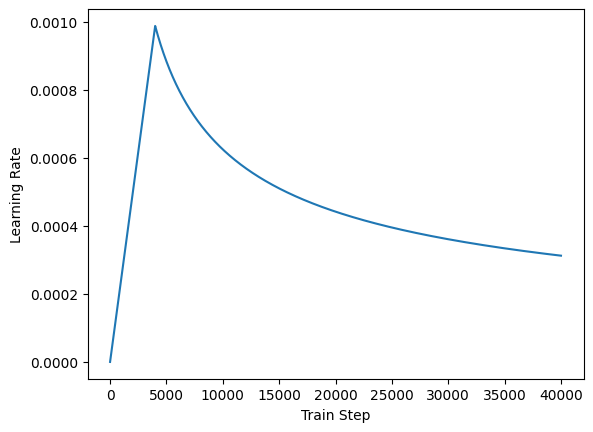

In [37]:
import matplotlib.pyplot as plt
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

The loss an accuracy functions must also be custom defined to work with masking and other particulars of this transformer's input/output design.

In [38]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=False, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [39]:
num_layers = 8
d_model = 128
dff = 32
num_heads = 8
dropout_rate = 0.15

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(encoder.get_vocabulary()),
    target_vocab_size=len(encoder.get_vocabulary()),
    dropout_rate=dropout_rate, name="outputs")

inputs = tf.keras.Input(shape=(None,), name="inputs")
dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")


outputs = transformer([inputs,dec_inputs])


model = tf.keras.models.Model(inputs={'inputs':inputs,'dec_inputs':dec_inputs}, outputs={'outputs':outputs})

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer_16' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'decoder_layer_4' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [40]:
model.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)       │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dec_inputs (InputLayer)   │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ outputs (Transformer)     │ (None, None, 8192)     │      4,882,944 │ inputs[0][0],          │
│                           │                        │                │ dec_inputs[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,882,944 (18.63 MB)

 Trainable params: 4,882,944 (18.63 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model({'inputs':encoded_qs[0:2],'dec_inputs':encoded_as[0:2,:1]})

{'outputs': <tf.Tensor: shape=(2, 1, 8192), dtype=float32, numpy=
 array([[[1.4838685e-04, 1.3290663e-04, 1.7989881e-04, ...,
          8.2328908e-05, 1.1958829e-04, 1.0774903e-04]],
 
        [[1.4530445e-04, 1.3164953e-04, 1.7812176e-04, ...,
          7.9417921e-05, 1.1753648e-04, 1.0351325e-04]]], dtype=float32)>}

In [44]:
model.fit(dataset, epochs=100)

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.6830 - loss: 0.1120
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.6843 - loss: 0.1138
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.6830 - loss: 0.1135
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.6836 - loss: 0.1128
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.6844 - loss: 0.1151
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.6822 - loss: 0.1157
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.6817 - loss: 0.1162
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.6814 - loss: 0.1191
Epoch 9/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.6820 - loss: 0.1089
Epoch 10/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.6842 - loss: 0.1130
Epoch 11/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.6835 - loss: 0.1150
Epoch 12/100
391/39

# Evaluate Some Predictions

In [45]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(encoder(sentence),0)

  output = tf.expand_dims([encoder.get_vocabulary().index('>')],0)
  for i in range(MAX_LENGTH):
    predictions = model({'inputs':sentence, 'dec_inputs':output}, training=False)

    # select the last word from the seq_len dimension
    predictions = predictions['outputs'][:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, encoder.get_vocabulary().index('|')):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)
  predicted_sentence = ''
  for word in prediction:
    predicted_sentence+=' '+encoder.get_vocabulary()[word]
  #predicted_sentence = encoder.decode(
  #    [i for i in prediction if i < encoder.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [46]:
predict('Where have you been?')

Input: Where have you been?
Output:  > things .


' > things .'

In [47]:
predict('What was the thing that happened to him?')

Input: What was the thing that happened to him?
Output:  > things .


' > things .'